In [1]:
# Packages laden
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Input, Dense
from matplotlib import pyplot as plt
from pandas import DataFrame
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Dropout, Activation, Flatten,TimeDistributed, BatchNormalization, LeakyReLU, Activation 
from keras.models import Model
from pandas import concat
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
ZR = ZR.reshape((len(ZR), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ZR)
ZR_N = scaler.transform(ZR)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_100_TR, ZR_100_TE= ZR_100[0:605], ZR_100[605:len(ZR_100)]
ZR_46_TR, ZR_46_TE= ZR_46[0:250], ZR_46[250:len(ZR_46)]

# Anteil der Datensätze am Gesamtdatensatz: normalisierte Daten
ZR_N100=ZR_N
ZR_N46=ZR_N[-400:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_N100_TR, ZR_N100_TE= ZR_N100[0:605], ZR_N100[605:len(ZR_N100)]
ZR_N46_TR, ZR_N46_TE= ZR_N46[0:250], ZR_N46[250:len(ZR_N46)]

In [6]:
# Funktion: Datensatz erstellen mit Inputs (look_back: Anzahl der verwendten Vergangenheitswerte) + Output (look_forward: 
# Vorhersagehorizont)
def timeseries_to_supervised_R(data, look_back, look_forward):
    df = DataFrame(data)
    columns = [df.shift(look_forward-1+i) for i in range(1, look_back+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    #df = df.drop(0)
    DF=df[::-1]
    df=DF[:len(df)-(look_back+look_forward-1)]
    DF=df[::-1]
    return DF

In [7]:
# Festlegung: look_back, look_forward + Anwendung der Funktion
# Inputneuronen: 12
# Vorhersagehorizont: t+60
look_back=12
look_forward=60

# Inputgröße 100%
# Trainingsdaten
ZR_100_TR_I=timeseries_to_supervised_R(ZR_100_TR, look_back, look_forward)
trainX_100, train_y_100 = ZR_100_TR_I.iloc[:, 0:-1], ZR_100_TR_I.iloc[:, -1]

# Testdaten 
ZR_100_TE_I=timeseries_to_supervised_R(ZR_100_TE, look_back, look_forward)
testX_100, test_y_100 = ZR_100_TE_I.iloc[:, 0:-1], ZR_100_TE_I.iloc[:, -1]


# Inputgröße 46%
# Trainingsdaten
ZR_46_TR_I=timeseries_to_supervised_R(ZR_46_TR, look_back, look_forward)
trainX_46, train_y_46 = ZR_46_TR_I.iloc[:, 0:-1], ZR_46_TR_I.iloc[:, -1]

# Testdaten 
ZR_46_TE_I=timeseries_to_supervised_R(ZR_46_TE, look_back, look_forward)
testX_46, test_y_46 = ZR_46_TE_I.iloc[:, 0:-1], ZR_46_TE_I.iloc[:, -1]

In [8]:
# Normalisierten Daten
# Inputgröße 100%
# Trainingsdaten
ZR_N100_TR_I=timeseries_to_supervised_R(ZR_N100_TR, look_back, look_forward)
trainX_100N, train_y_100N = ZR_N100_TR_I.iloc[:, 0:-1], ZR_N100_TR_I.iloc[:, -1]

# Testdaten 
ZR_N100_TE_I=timeseries_to_supervised_R(ZR_N100_TE, look_back, look_forward)
testX_100N, test_y_100N = ZR_N100_TE_I.iloc[:, 0:-1], ZR_N100_TE_I.iloc[:, -1]


# Inputgröße 46%
# Trainingsdaten
ZR_N46_TR_I=timeseries_to_supervised_R(ZR_N46_TR, look_back, look_forward)
trainX_46N, train_y_46N = ZR_N46_TR_I.iloc[:, 0:-1], ZR_N46_TR_I.iloc[:, -1]

# Testdaten 
ZR_N46_TE_I=timeseries_to_supervised_R(ZR_N46_TE, look_back, look_forward)
testX_46N, test_y_46N = ZR_N46_TE_I.iloc[:, 0:-1], ZR_N46_TE_I.iloc[:, -1]

In [33]:
# Replizierbarkeit gewährleisten
np.random.seed(1)

In [34]:
# Modell zusammenbauen
# Dateninput: 100 %
model = Sequential()
model.add(Dense(5, input_dim=look_back, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_100N, train_y_100N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_100N, test_y_100N))

Train on 534 samples, validate on 187 samples
Epoch 1/200
 - 1s - loss: 0.1254 - val_loss: 0.2665
Epoch 2/200
 - 0s - loss: 0.0766 - val_loss: 0.1915
Epoch 3/200
 - 0s - loss: 0.0593 - val_loss: 0.1546
Epoch 4/200
 - 0s - loss: 0.0553 - val_loss: 0.1383
Epoch 5/200
 - 0s - loss: 0.0539 - val_loss: 0.1260
Epoch 6/200
 - 0s - loss: 0.0523 - val_loss: 0.1242
Epoch 7/200
 - 0s - loss: 0.0508 - val_loss: 0.1153
Epoch 8/200
 - 0s - loss: 0.0492 - val_loss: 0.1112
Epoch 9/200
 - 0s - loss: 0.0477 - val_loss: 0.1012
Epoch 10/200
 - 0s - loss: 0.0462 - val_loss: 0.0959
Epoch 11/200
 - 0s - loss: 0.0449 - val_loss: 0.0900
Epoch 12/200
 - 0s - loss: 0.0435 - val_loss: 0.0843
Epoch 13/200
 - 0s - loss: 0.0423 - val_loss: 0.0779
Epoch 14/200
 - 0s - loss: 0.0411 - val_loss: 0.0706
Epoch 15/200
 - 0s - loss: 0.0400 - val_loss: 0.0684
Epoch 16/200
 - 0s - loss: 0.0389 - val_loss: 0.0622
Epoch 17/200
 - 0s - loss: 0.0380 - val_loss: 0.0578
Epoch 18/200
 - 0s - loss: 0.0371 - val_loss: 0.0543
Epoch 19/

Epoch 154/200
 - 0s - loss: 0.0251 - val_loss: 0.0070
Epoch 155/200
 - 0s - loss: 0.0252 - val_loss: 0.0070
Epoch 156/200
 - 0s - loss: 0.0250 - val_loss: 0.0073
Epoch 157/200
 - 0s - loss: 0.0250 - val_loss: 0.0068
Epoch 158/200
 - 0s - loss: 0.0251 - val_loss: 0.0066
Epoch 159/200
 - 0s - loss: 0.0249 - val_loss: 0.0072
Epoch 160/200
 - 0s - loss: 0.0249 - val_loss: 0.0067
Epoch 161/200
 - 0s - loss: 0.0250 - val_loss: 0.0067
Epoch 162/200
 - 0s - loss: 0.0248 - val_loss: 0.0071
Epoch 163/200
 - 0s - loss: 0.0248 - val_loss: 0.0067
Epoch 164/200
 - 0s - loss: 0.0248 - val_loss: 0.0070
Epoch 165/200
 - 0s - loss: 0.0248 - val_loss: 0.0069
Epoch 166/200
 - 0s - loss: 0.0250 - val_loss: 0.0069
Epoch 167/200
 - 0s - loss: 0.0247 - val_loss: 0.0069
Epoch 168/200
 - 0s - loss: 0.0249 - val_loss: 0.0065
Epoch 169/200
 - 0s - loss: 0.0246 - val_loss: 0.0069
Epoch 170/200
 - 0s - loss: 0.0247 - val_loss: 0.0068
Epoch 171/200
 - 0s - loss: 0.0246 - val_loss: 0.0071
Epoch 172/200
 - 0s - loss: 

Text(0.5,1,'Loss Curves')

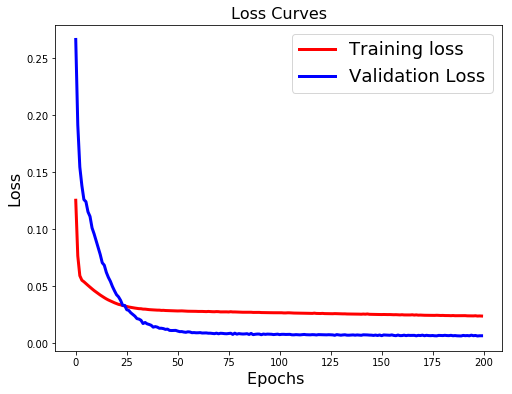

In [35]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [36]:
# Modellperformance bewerten: normalisierte Daten
trainScore = model.evaluate(trainX_100N, train_y_100N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_100N, test_y_100N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.02 MSE (0.15 RMSE)
Test Score: 0.01 MSE (0.08 RMSE)


In [37]:
# Vorhersagen generieren
trainPredict_100N = model.predict(trainX_100N)
testPredict_100N = model.predict(testX_100N)

In [38]:
# Prediction Denormalizing
testPredict_100=scaler.inverse_transform(testPredict_100N)
trainPredict_100=scaler.inverse_transform(trainPredict_100N)

# Evaluation
test_MSE=mean_squared_error(test_y_100,testPredict_100)
train_MSE=mean_squared_error(train_y_100,trainPredict_100)

print(test_MSE,train_MSE)

38657045.068878666 139896424.84001374


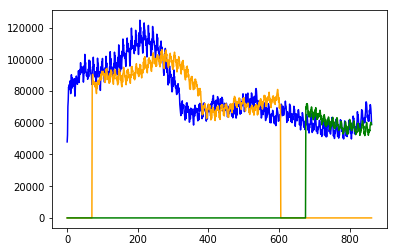

In [39]:
# Verschiebund der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_100))
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_100)+(look_back+look_forward-1)] = trainPredict_100

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot=testPredictPlot.reshape(len(ZR_100))
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(trainPredict_100)+(2*look_back+2*look_forward-2):len(ZR_100)-(look_back+look_forward-1)+look_back+look_forward] = testPredict_100
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [40]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [41]:
# Modell zusammenbauen
# Dateninput: 46 %
model = Sequential()
model.add(Dense(5, input_dim=look_back, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_46N, train_y_46N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_46N, test_y_46N))

Train on 179 samples, validate on 79 samples
Epoch 1/200
 - 1s - loss: 0.0334 - val_loss: 0.0320
Epoch 2/200
 - 0s - loss: 0.0197 - val_loss: 0.0216
Epoch 3/200
 - 0s - loss: 0.0111 - val_loss: 0.0147
Epoch 4/200
 - 0s - loss: 0.0068 - val_loss: 0.0107
Epoch 5/200
 - 0s - loss: 0.0051 - val_loss: 0.0088
Epoch 6/200
 - 0s - loss: 0.0049 - val_loss: 0.0080
Epoch 7/200
 - 0s - loss: 0.0051 - val_loss: 0.0078
Epoch 8/200
 - 0s - loss: 0.0051 - val_loss: 0.0079
Epoch 9/200
 - 0s - loss: 0.0050 - val_loss: 0.0083
Epoch 10/200
 - 0s - loss: 0.0050 - val_loss: 0.0085
Epoch 11/200
 - 0s - loss: 0.0050 - val_loss: 0.0085
Epoch 12/200
 - 0s - loss: 0.0050 - val_loss: 0.0086
Epoch 13/200
 - 0s - loss: 0.0050 - val_loss: 0.0087
Epoch 14/200
 - 0s - loss: 0.0049 - val_loss: 0.0087
Epoch 15/200
 - 0s - loss: 0.0049 - val_loss: 0.0085
Epoch 16/200
 - 0s - loss: 0.0049 - val_loss: 0.0081
Epoch 17/200
 - 0s - loss: 0.0049 - val_loss: 0.0079
Epoch 18/200
 - 0s - loss: 0.0049 - val_loss: 0.0080
Epoch 19/2

Epoch 154/200
 - 0s - loss: 0.0040 - val_loss: 0.0049
Epoch 155/200
 - 0s - loss: 0.0040 - val_loss: 0.0051
Epoch 156/200
 - 0s - loss: 0.0040 - val_loss: 0.0050
Epoch 157/200
 - 0s - loss: 0.0040 - val_loss: 0.0048
Epoch 158/200
 - 0s - loss: 0.0040 - val_loss: 0.0048
Epoch 159/200
 - 0s - loss: 0.0039 - val_loss: 0.0049
Epoch 160/200
 - 0s - loss: 0.0039 - val_loss: 0.0049
Epoch 161/200
 - 0s - loss: 0.0039 - val_loss: 0.0048
Epoch 162/200
 - 0s - loss: 0.0040 - val_loss: 0.0049
Epoch 163/200
 - 0s - loss: 0.0039 - val_loss: 0.0049
Epoch 164/200
 - 0s - loss: 0.0039 - val_loss: 0.0049
Epoch 165/200
 - 0s - loss: 0.0039 - val_loss: 0.0049
Epoch 166/200
 - 0s - loss: 0.0039 - val_loss: 0.0050
Epoch 167/200
 - 0s - loss: 0.0039 - val_loss: 0.0048
Epoch 168/200
 - 0s - loss: 0.0039 - val_loss: 0.0049
Epoch 169/200
 - 0s - loss: 0.0039 - val_loss: 0.0049
Epoch 170/200
 - 0s - loss: 0.0039 - val_loss: 0.0048
Epoch 171/200
 - 0s - loss: 0.0039 - val_loss: 0.0047
Epoch 172/200
 - 0s - loss: 

Text(0.5,1,'Loss Curves')

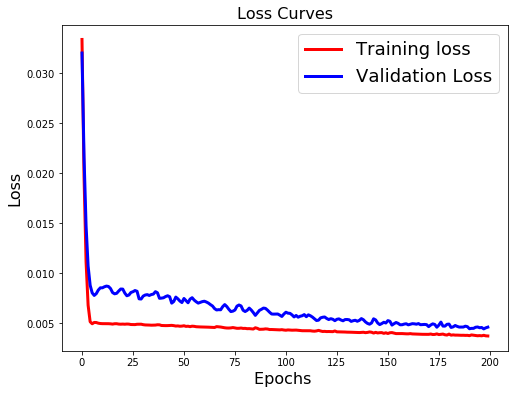

In [42]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [43]:
# Modellperformance bewerten
trainScore = model.evaluate(trainX_46N, train_y_46N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_46N, test_y_46N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.06 RMSE)
Test Score: 0.00 MSE (0.07 RMSE)


In [44]:
# Vorhersagen generieren
trainPredict_46N = model.predict(trainX_46N)
testPredict_46N = model.predict(testX_46N)

In [45]:
# Prediction Denormalizing
testPredict_46=scaler.inverse_transform(testPredict_46N)
trainPredict_46=scaler.inverse_transform(trainPredict_46N)

# Evaluation
test_MSE=mean_squared_error(test_y_46,testPredict_46)
train_MSE=mean_squared_error(train_y_46,trainPredict_46)

print(test_MSE,train_MSE)

27072811.827334248 21908209.052815273


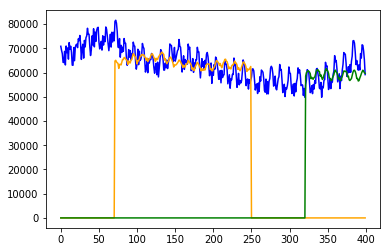

In [46]:
# Verschiebund der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_46)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_46))
trainPredictPlot[:]=[0]*len(ZR_46)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_46),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_46)+(look_back+look_forward-1)] = trainPredict_46

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_46)
testPredictPlot=testPredictPlot.reshape(len(ZR_46))
testPredictPlot[:]=[0]*len(ZR_46)
testPredictPlot = testPredictPlot.reshape(len(ZR_46),1)
testPredictPlot[len(trainPredict_46)+2*(look_back+look_forward-1):len(ZR_46)-(look_back+look_forward-1)+look_back+look_forward] = testPredict_46
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_46,color='blue')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()